In [1]:
import zipfile
import tensorflow as tf
import os

os.environ["CUDA_VISIBLE_DEVICES"]="0"
with tf.device('/gpu:0'):
    a = tf.constant([1.0, 2.0, 3.0, 4.0, 5.0, 6.0], shape=[2, 3], name='a')
    b = tf.constant([1.0, 2.0, 3.0, 4.0, 5.0, 6.0], shape=[3, 2], name='b')
    c = tf.matmul(a, b)
config = tf.ConfigProto()
config.gpu_options.allow_growth = True
session = tf.Session(config=config)
print (session.run(c))

[[22. 28.]
 [49. 64.]]


In [2]:
from keras.layers import *
from keras.models import *
from keras.preprocessing.image import ImageDataGenerator
from keras.losses import *
from keras.optimizers import *
from keras.callbacks import *
from keras.regularizers import *
import time
import pickle
import matplotlib.pyplot as plt
import keras.backend as K
from skimage.io import imread
from skimage.transform import resize

from keras.applications.densenet import DenseNet201, preprocess_input

Using TensorFlow backend.


In [7]:
del(encoder)
del(decoder)
del(vae)

In [3]:
# VAE model = encoder + decoder
# build encoder model
latent_dim = (4,4,64)
input_shape=(18,18,736)

def sampling(args):
    """Reparameterization trick by sampling from an isotropic unit Gaussian.
    # Arguments
        args (tensor): mean and log of variance of Q(z|X)
    # Returns
        z (tensor): sampled latent vector
    """

    z_mean, z_log_var = args
    # by default, random_normal has mean = 0 and std = 1.0
    epsilon = K.random_normal(shape=(latent_dim))
    return z_mean + K.exp(0.5 * z_log_var) * epsilon

inputs = Input(shape=input_shape, name='encoder_input')

x = Conv2D(256, (3,3), strides=2, padding='same', name='conv_256_0')(inputs)
x = BatchNormalization()(x)
x = ReLU()(x)

x = Conv2D(128, (3,3), strides=2, padding='valid', name='conv_256_1')(x)
x = BatchNormalization()(x)
x = ReLU()(x)

z_mean = Dense(64, name='z_mean')(x)
z_log_var = Dense(64, name='z_log_var')(x)

# use reparameterization trick to push the sampling out as input
# note that "output_shape" isn't necessary with the TensorFlow backend
z = Lambda(sampling, name='z')([z_mean, z_log_var])

# instantiate encoder model
encoder = Model(inputs, [z_mean, z_log_var, z], name='encoder')
encoder.summary()

# build decoder model
latent_inputs = Input(shape=(latent_dim), name='z_sampling')

# x = Dense(4*4*2024, activation='relu')(latent_inputs)
# x = Reshape((4,4,2024))(x)
x = Conv2DTranspose(1024, (3,3), strides=2, padding='valid')(latent_inputs)
# x = LeakyReLU()(x)
x = BatchNormalization()(x)

x = Conv2DTranspose(736, (3,3), strides=2, padding='same')(x)
# x = LeakyReLU()(x)
outputs = BatchNormalization()(x)

# instantiate decoder model
decoder = Model(latent_inputs, outputs, name='decoder')
decoder.summary()

# instantiate VAE model
outputs = decoder(encoder(inputs)[2])
vae = Model(inputs, outputs, name='vae')

def vae_loss(z_mean=z_mean,z_log_var=z_log_var):
    def loss(inputs, outputs):
        xent_loss = binary_crossentropy(inputs, outputs)
        kl_loss = - 0.5 * K.mean(1 + z_log_var - K.square(z_mean) - 
                    K.exp(z_log_var), axis=-1)
        return  K.mean(xent_loss)+kl_loss
    return loss

vae.compile(optimizer='adam', loss=vae_loss(z_mean, z_log_var))

W1213 11:05:25.297546 140394893289216 deprecation_wrapper.py:119] From /usr/local/lib/python3.5/dist-packages/keras/backend/tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W1213 11:05:25.299349 140394893289216 deprecation_wrapper.py:119] From /usr/local/lib/python3.5/dist-packages/keras/backend/tensorflow_backend.py:4138: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.

W1213 11:05:25.309837 140394893289216 deprecation_wrapper.py:119] From /usr/local/lib/python3.5/dist-packages/keras/backend/tensorflow_backend.py:74: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W1213 11:05:25.319709 140394893289216 deprecation_wrapper.py:119] From /usr/local/lib/python3.5/dist-packages/keras/backend/tensorflow_backend.py:174: The name tf.get_default_session is deprecated. Please use tf.compat.v1.get_default_session instead.

W1213 11:05:25.320166 1403948932

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
encoder_input (InputLayer)      (None, 18, 18, 736)  0                                            
__________________________________________________________________________________________________
conv_256_0 (Conv2D)             (None, 9, 9, 256)    1696000     encoder_input[0][0]              
__________________________________________________________________________________________________
batch_normalization_1 (BatchNor (None, 9, 9, 256)    1024        conv_256_0[0][0]                 
__________________________________________________________________________________________________
re_lu_1 (ReLU)                  (None, 9, 9, 256)    0           batch_normalization_1[0][0]      
__________________________________________________________________________________________________
conv_256_1

W1213 11:05:25.937144 140394893289216 deprecation_wrapper.py:119] From /usr/local/lib/python3.5/dist-packages/keras/optimizers.py:790: The name tf.train.Optimizer is deprecated. Please use tf.compat.v1.train.Optimizer instead.

W1213 11:05:25.954972 140394893289216 deprecation.py:323] From /usr/local/lib/python3.5/dist-packages/tensorflow/python/ops/nn_impl.py:180: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


In [6]:
vae_loss

<tf.Tensor 'Mean_1:0' shape=() dtype=float32>

In [4]:
import os
from keras.preprocessing.image import ImageDataGenerator

batch_size = 32

train_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

root_path = '/data/Quan/datasets/webcam'
train_generator = train_datagen.flow_from_directory(os.path.join(root_path, 'images'), 
                                                    class_mode='categorical', 
                                                    target_size=(300,300), 
                                                    batch_size=batch_size, 
                                                    shuffle=True)

validation_generator = test_datagen.flow_from_directory(os.path.join(root_path, 'val_images'), 
                                                        class_mode='categorical', 
                                                        target_size=(300,300), 
                                                        batch_size=batch_size, 
                                                        shuffle=False)

test_generator = test_datagen.flow_from_directory(os.path.join(root_path, 'test_images'), 
                                                        class_mode='categorical', 
                                                        target_size=(300,300), 
                                                        batch_size=1, 
                                                        shuffle=False)

label_dict = test_generator.class_indices

Found 444 images belonging to 31 classes.
Found 112 images belonging to 31 classes.
Found 239 images belonging to 31 classes.


In [5]:
with open('/data/Quan/tf_models/amazon/extracted_features.hdf5', 'rb') as dt:
    s_labels, s_features = pickle.load(dt)
    
with open('/data/Quan/tf_models/amazon/val_extracted_features.hdf5', 'rb') as dt:
    sval_labels, sval_features = pickle.load(dt)
    
with open('/data/Quan/tf_models/webcam/extracted_features.hdf5', 'rb') as dt:
    t_labels, t_features = pickle.load(dt)
    
with open('/data/Quan/tf_models/webcam/val_extracted_features.hdf5', 'rb') as dt:
    tval_labels, tval_features = pickle.load(dt)

with open('/data/Quan/tf_models/webcam/t_test_features.hdf5', 'rb') as dt:
    ttest_labels, ttest_features = pickle.load(dt)

# s_labels = [k.split('/')[-2] for k in s_labels]
# sval_labels = [k.split('/')[-2] for k in sval_labels]

t_labels = [k.split('/')[-2] for k in t_labels]
tval_labels = [k.split('/')[-2] for k in tval_labels]
    
# s_features.shape, sval_features.shape, t_features.shape

## Amazon

In [6]:
batch_size=32
mcp = ModelCheckpoint('/data/Quan/tf_models/amazon/convvae2_model.hdf5', monitor='val_loss', 
                      save_best_only=True, save_weights_only=False)

start = time.time()
history = vae.fit(s_features, s_features, batch_size=batch_size, epochs=100, 
          validation_data=(sval_features, sval_features), callbacks=[mcp], verbose=1)

exe_time = time.time() - start

print('exe time: ', exe_time)
with open('/data/Quan/tf_models/amazon/convvae2_history.hdf5', 'wb') as dt:
    pickle.dump(history.history, dt)
    

Train on 1576 samples, validate on 395 samples
Epoch 1/100
1576/1576 [==============================] - 7s 5ms/step - loss: 4.8331 - val_loss: 4.3379
Epoch 2/100
1576/1576 [==============================] - 5s 3ms/step - loss: 2.8359 - val_loss: 2.7726
Epoch 3/100
1576/1576 [==============================] - 5s 3ms/step - loss: 2.0376 - val_loss: 1.7127
Epoch 4/100
1576/1576 [==============================] - 5s 3ms/step - loss: 1.6190 - val_loss: 1.2782
Epoch 5/100
1576/1576 [==============================] - 5s 3ms/step - loss: 1.4507 - val_loss: 1.6733
Epoch 6/100
1576/1576 [==============================] - 5s 3ms/step - loss: 1.3993 - val_loss: 1.4078
Epoch 7/100
1576/1576 [==============================] - 5s 3ms/step - loss: 1.1188 - val_loss: 1.1148
Epoch 8/100
1576/1576 [==============================] - 5s 3ms/step - loss: 0.9946 - val_loss: 0.9077
Epoch 9/100
1576/1576 [==============================] - 5s 3ms/step - loss: 0.8514 - val_loss: 0.7919
Epoch 10/100
1576/1576 [==

1576/1576 [==============================] - 4s 3ms/step - loss: -1.3328 - val_loss: -1.5448
Epoch 79/100
1576/1576 [==============================] - 5s 3ms/step - loss: -1.3346 - val_loss: -1.6142
Epoch 80/100
1576/1576 [==============================] - 5s 3ms/step - loss: -1.3695 - val_loss: -1.5912
Epoch 81/100
1576/1576 [==============================] - 5s 3ms/step - loss: -1.3759 - val_loss: -1.5821
Epoch 82/100
1576/1576 [==============================] - 5s 3ms/step - loss: -1.3804 - val_loss: -1.5916
Epoch 83/100
1576/1576 [==============================] - 5s 3ms/step - loss: -1.3750 - val_loss: -1.5052
Epoch 84/100
1576/1576 [==============================] - 5s 3ms/step - loss: -1.3669 - val_loss: -1.6143
Epoch 85/100
1576/1576 [==============================] - 4s 3ms/step - loss: -1.3936 - val_loss: -1.6251
Epoch 86/100
1576/1576 [==============================] - 4s 3ms/step - loss: -1.4152 - val_loss: -1.6178
Epoch 87/100
1576/1576 [==============================] - 5

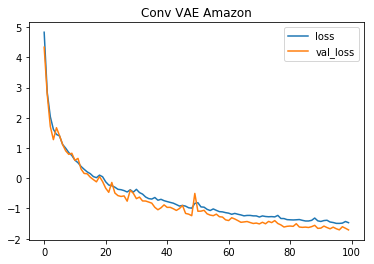

In [7]:
plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.legend()
plt.title('Conv VAE Amazon')
plt.show()

## Webcam

In [8]:
batch_size=32
mcp = ModelCheckpoint('/data/Quan/tf_models/webcam/convvae2_model.hdf5', monitor='val_loss', 
                      save_best_only=True, save_weights_only=False)

start = time.time()
history = vae.fit(t_features, t_features, batch_size=batch_size, epochs=100, 
          validation_data=(tval_features, tval_features), callbacks=[mcp], verbose=1)

exe_time = time.time() - start

print('exe time: ', exe_time)
with open('/data/Quan/tf_models/webcam/convvae2_history.hdf5', 'wb') as dt:
    pickle.dump(history.history, dt)
    

Train on 444 samples, validate on 112 samples
Epoch 1/100
444/444 [==============================] - 2s 4ms/step - loss: 1.0604 - val_loss: 0.6512
Epoch 2/100
444/444 [==============================] - 1s 3ms/step - loss: 0.9841 - val_loss: 0.6977
Epoch 3/100
444/444 [==============================] - 1s 3ms/step - loss: 0.9455 - val_loss: 0.7414
Epoch 4/100
444/444 [==============================] - 1s 3ms/step - loss: 0.8818 - val_loss: 0.7922
Epoch 5/100
444/444 [==============================] - 1s 3ms/step - loss: 0.8205 - val_loss: 0.8799
Epoch 6/100
444/444 [==============================] - 1s 3ms/step - loss: 0.8158 - val_loss: 0.9062
Epoch 7/100
444/444 [==============================] - 1s 3ms/step - loss: 0.7828 - val_loss: 0.9661
Epoch 8/100
444/444 [==============================] - 1s 3ms/step - loss: 0.7583 - val_loss: 0.8746
Epoch 9/100
444/444 [==============================] - 1s 3ms/step - loss: 0.7111 - val_loss: 0.8261
Epoch 10/100
444/444 [=======================

Epoch 81/100
444/444 [==============================] - 1s 3ms/step - loss: 0.2045 - val_loss: 0.1894
Epoch 82/100
444/444 [==============================] - 1s 3ms/step - loss: 0.2183 - val_loss: 0.2406
Epoch 83/100
444/444 [==============================] - 1s 3ms/step - loss: 0.2423 - val_loss: 0.3511
Epoch 84/100
444/444 [==============================] - 1s 3ms/step - loss: 0.2272 - val_loss: 0.1719
Epoch 85/100
444/444 [==============================] - 1s 3ms/step - loss: 0.2192 - val_loss: 0.1144
Epoch 86/100
444/444 [==============================] - 1s 3ms/step - loss: 0.2011 - val_loss: 0.1166
Epoch 87/100
444/444 [==============================] - 1s 3ms/step - loss: 0.2153 - val_loss: 0.1285
Epoch 88/100
444/444 [==============================] - 1s 3ms/step - loss: 0.1701 - val_loss: 0.1103
Epoch 89/100
444/444 [==============================] - 1s 3ms/step - loss: 0.1692 - val_loss: 0.0807
Epoch 90/100
444/444 [==============================] - 1s 3ms/step - loss: 0.1651

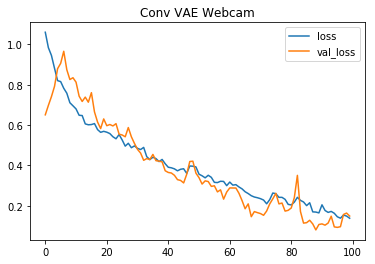

In [9]:
plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.legend()
plt.title('Conv VAE Webcam')
plt.show()

## Combine VAE

In [10]:
import keras.losses
keras.losses.vae_loss = vae_loss

s_vae = load_model('/data/Quan/tf_models/amazon/convvae2_model.hdf5',custom_objects={'latent_dim': latent_dim, 'loss': vae_loss(z_mean,z_log_var)})
t_vae = load_model('/data/Quan/tf_models/webcam/convvae2_model.hdf5',custom_objects={'latent_dim': latent_dim, 'loss': vae_loss(z_mean,z_log_var)})

s_vae.summary()
t_vae.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
encoder_input (InputLayer)   (None, 18, 18, 736)       0         
_________________________________________________________________
encoder (Model)              [(None, 4, 4, 64), (None, 2009088   
_________________________________________________________________
decoder (Model)              (None, 18, 18, 736)       7381600   
Total params: 9,390,688
Trainable params: 9,386,400
Non-trainable params: 4,288
_________________________________________________________________
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
encoder_input (InputLayer)   (None, 18, 18, 736)       0         
_________________________________________________________________
encoder (Model)              [(None, 4, 4, 64), (None, 2009088   
______________________________________________________________

In [11]:
t_encoder = Model(t_vae.get_layer('encoder').inputs, t_vae.get_layer('encoder').outputs, name='t_encoder')
s_decoder = Model(s_vae.get_layer('decoder').inputs, s_vae.get_layer('decoder').outputs, name='s_decoder')

t_encoder.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
encoder_input (InputLayer)      (None, 18, 18, 736)  0                                            
__________________________________________________________________________________________________
conv_256_0 (Conv2D)             (None, 9, 9, 256)    1696000     encoder_input[0][0]              
__________________________________________________________________________________________________
batch_normalization_1 (BatchNor (None, 9, 9, 256)    1024        conv_256_0[0][0]                 
__________________________________________________________________________________________________
re_lu_1 (ReLU)                  (None, 9, 9, 256)    0           batch_normalization_1[0][0]      
__________________________________________________________________________________________________
conv_256_1

In [12]:
c_vae_outputs = s_decoder(t_encoder(t_encoder.inputs)[2])
c_vae = Model(t_encoder.inputs, c_vae_outputs, name='combined_vae')
c_vae.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
encoder_input (InputLayer)   (None, 18, 18, 736)       0         
_________________________________________________________________
t_encoder (Model)            [(None, 4, 4, 64), (None, 2009088   
_________________________________________________________________
s_decoder (Model)            (None, 18, 18, 736)       7381600   
Total params: 9,390,688
Trainable params: 9,386,400
Non-trainable params: 4,288
_________________________________________________________________


In [13]:
t_num_labels = [label_dict[k] for k in t_labels]
tval_num_labels = [label_dict[k] for k in tval_labels]
ttest_num_labels = [label_dict[k] for k in ttest_labels]

t_num_labels = keras.utils.to_categorical(t_num_labels, 31)
tval_num_labels = keras.utils.to_categorical(tval_num_labels, 31)
ttest_num_labels = keras.utils.to_categorical(ttest_num_labels, 31)

transform_features = c_vae.predict(t_features, verbose=1)
val_transform_features = c_vae.predict(tval_features, verbose=1)
test_transform_features = c_vae.predict(ttest_features, verbose=1)

239/239 [==============================] - 0s 2ms/step


In [14]:
# retrain source classifier

# Get source classififer (amazon)
s_baseline = load_model('/data/Quan/tf_models/amazon/baseline_model.hdf5')
s_baseline.summary()

input_model = Input(shape=(18,18,736))
x = GlobalAveragePooling2D()(input_model)
x = Dropout(0.3)(x)
x = Dense(31)(x)
x = BatchNormalization()(x)
x = Activation('softmax')(x)

s_topmodel = Model(input_model, x)

for i in range(-3,-1):
#     print(s_topmodel.layers[i+6].name, s_baseline.layers[i].name)
    s_topmodel.layers[i].set_weights(s_baseline.layers[i].get_weights())

s_topmodel.compile(loss='categorical_crossentropy', optimizer=Adam(), metrics=['accuracy'])
s_topmodel.summary()

W1213 11:18:06.557283 140394893289216 deprecation_wrapper.py:119] From /usr/local/lib/python3.5/dist-packages/keras/backend/tensorflow_backend.py:3976: The name tf.nn.max_pool is deprecated. Please use tf.nn.max_pool2d instead.

W1213 11:18:07.195171 140394893289216 deprecation.py:506] From /usr/local/lib/python3.5/dist-packages/keras/backend/tensorflow_backend.py:3445: calling dropout (from tensorflow.python.ops.nn_ops) with keep_prob is deprecated and will be removed in a future version.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 300, 300, 3)  0                                            
__________________________________________________________________________________________________
conv0_block0 (Conv2D)           (None, 300, 300, 32) 896         input_1[0][0]                    
__________________________________________________________________________________________________
batchnorm0_block0 (BatchNormali (None, 300, 300, 32) 128         conv0_block0[0][0]               
__________________________________________________________________________________________________
relu0_block0 (Activation)       (None, 300, 300, 32) 0           batchnorm0_block0[0][0]          
__________________________________________________________________________________________________
conv1_bloc

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 18, 18, 736)       0         
_________________________________________________________________
global_average_pooling2d_1 ( (None, 736)               0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 736)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 31)                22847     
_________________________________________________________________
batch_normalization_5 (Batch (None, 31)                124       
_________________________________________________________________
activation_1 (Activation)    (None, 31)                0         
Total params: 22,971
Trainable params: 22,909
Non-trainable params: 62
_________________________________________________________________


In [23]:
s_topmodel.evaluate(test_transform_features, ttest_num_labels, verbose=1)

239/239 [==============================] - 1s 3ms/step


[4.008128966247686, 0.04184100418410042]

In [15]:
mcp = ModelCheckpoint('/data/Quan/tf_models/webcam/amazon_conv2_classifier_model.hdf5', monitor='val_acc', 
                      save_best_only=True, save_weights_only=False)

start = time.time()
history = s_topmodel.fit(transform_features, t_num_labels, batch_size=32, epochs=100,
               validation_data=(val_transform_features, tval_num_labels), verbose=1, callbacks=[mcp])

with open('/data/Quan/tf_models/webcam/amazon_conv2_classifier_history.hdf5', 'wb') as dt:
    pickle.dump(history, dt)
    
exe_time = time.time() - start

print('exe time: ', exe_time)

Train on 444 samples, validate on 112 samples
Epoch 1/100
444/444 [==============================] - 1s 3ms/step - loss: 4.2682 - acc: 0.0473 - val_loss: 3.2106 - val_acc: 0.0982
Epoch 2/100
444/444 [==============================] - 0s 471us/step - loss: 3.3167 - acc: 0.1441 - val_loss: 2.9855 - val_acc: 0.1964
Epoch 3/100
444/444 [==============================] - 0s 474us/step - loss: 2.8514 - acc: 0.2027 - val_loss: 2.7765 - val_acc: 0.2321
Epoch 4/100
444/444 [==============================] - 0s 471us/step - loss: 2.6281 - acc: 0.2545 - val_loss: 2.6641 - val_acc: 0.1875
Epoch 5/100
444/444 [==============================] - 0s 471us/step - loss: 2.4143 - acc: 0.3311 - val_loss: 2.5798 - val_acc: 0.2054
Epoch 6/100
444/444 [==============================] - 0s 470us/step - loss: 2.2793 - acc: 0.3468 - val_loss: 2.4395 - val_acc: 0.2768
Epoch 7/100
444/444 [==============================] - 0s 478us/step - loss: 2.1071 - acc: 0.3851 - val_loss: 2.3112 - val_acc: 0.3125
Epoch 8/100

Epoch 61/100
444/444 [==============================] - 0s 471us/step - loss: 1.3382 - acc: 0.6374 - val_loss: 1.5933 - val_acc: 0.6429
Epoch 62/100
444/444 [==============================] - 0s 469us/step - loss: 1.3694 - acc: 0.6712 - val_loss: 1.5824 - val_acc: 0.6339
Epoch 63/100
444/444 [==============================] - 0s 472us/step - loss: 1.4044 - acc: 0.6194 - val_loss: 1.5938 - val_acc: 0.6161
Epoch 64/100
444/444 [==============================] - 0s 473us/step - loss: 1.3496 - acc: 0.6554 - val_loss: 1.6018 - val_acc: 0.5893
Epoch 65/100
444/444 [==============================] - 0s 471us/step - loss: 1.3512 - acc: 0.6441 - val_loss: 1.5634 - val_acc: 0.6250
Epoch 66/100
444/444 [==============================] - 0s 477us/step - loss: 1.3094 - acc: 0.6689 - val_loss: 1.5600 - val_acc: 0.6250
Epoch 67/100
444/444 [==============================] - 0s 480us/step - loss: 1.3588 - acc: 0.6374 - val_loss: 1.5548 - val_acc: 0.6518
Epoch 68/100
444/444 [==========================

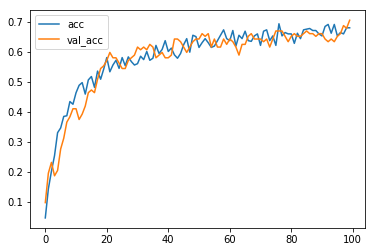

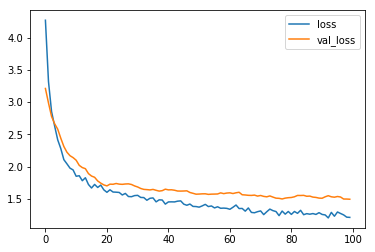

In [16]:
%matplotlib inline
plt.plot(history.history['acc'], label='acc')
plt.plot(history.history['val_acc'], label='val_acc')
plt.legend()
plt.show()

plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.legend()
plt.show()

In [17]:
test_topmodel = load_model('/data/Quan/tf_models/webcam/amazon_conv2_classifier_model.hdf5')
test_topmodel.evaluate(test_transform_features, ttest_num_labels, verbose=1)

239/239 [==============================] - 0s 2ms/step


[1.8303888322917987, 0.48535564953313215]